In [ ]:
!git clone https://github.com/pjreddie/darknet.git
%cd darknet
!make

In [ ]:
with open("custom.names", "w") as f:
    f.write("Helmet\nLicense Plate")

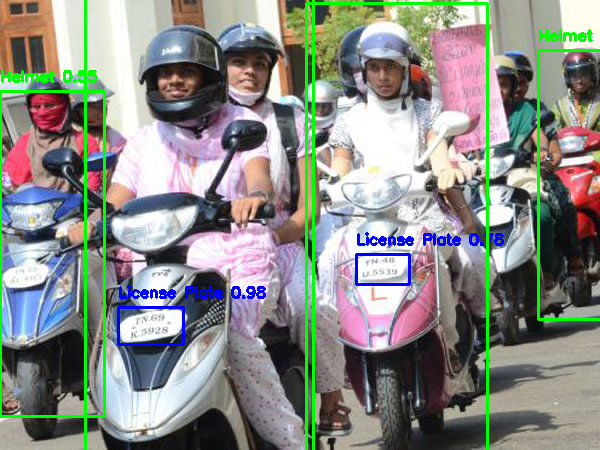

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

weights_path = "/content/drive/MyDrive/yolov3-custom_7000.weights"
cfg_path = "/content/drive/MyDrive/yolov3-custom.cfg"

net = cv2.dnn.readNet(weights_path, cfg_path)

with open("custom.names", "r") as f:
    classes = f.read().strip().split("\n")

image_path = "/content/drive/MyDrive/file/BikesHelmets97.png"
image = cv2.imread(image_path)
height, width = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

outs = net.forward(output_layers)

boxes, confidences, class_ids = [], [], []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        if confidence > 0.5:
            center_x, center_y, w, h = (detection[:4] * np.array([width, height, width, height])).astype("int")
            x, y = int(center_x - w / 2), int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

for i in indices.flatten():
    x, y, w, h = boxes[i]
    label = classes[class_ids[i]]
    confidence = confidences[i]

    if label == "Helmet":
        color = (0, 255, 0)  # Green
    elif label == "License Plate":
        color = (255, 0, 0)  # Blue
    else:
        color = (255, 255, 255)  # White for unknown labels

    cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
    cv2.putText(image, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

cv2_imshow(image)

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

weights_path = "/content/drive/MyDrive/yolov3-custom_7000.weights"
cfg_path = "/content/drive/MyDrive/yolov3-custom.cfg"

net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

with open("custom.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

required_classes = ["Helmet", "License Plate"]
for cls in required_classes:
    if cls not in classes:
        raise ValueError(f"{cls} class not found in custom.names!")

helmet_class_id = classes.index("Helmet")
license_plate_class_id = classes.index("License Plate")

video_path = "/content/drive/MyDrive/video.mp4"
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    height, width, _ = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    output_layers = net.getUnconnectedOutLayersNames()
    outs = net.forward(output_layers)

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5 and class_id in [helmet_class_id, license_plate_class_id]:
                center_x, center_y, w, h = detection[:4] * np.array([width, height, width, height])
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                w, h = int(w), int(h)

                if class_id == helmet_class_id:
                    label = "Helmet"
                    color = (0, 255, 0)  # Green
                else:
                    label = "License Plate"
                    color = (255, 0, 0)  # Blue

                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
                cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    cv2_imshow(frame)

cap.release()
cv2.destroyAllWindows()